# Using Cleanlab to Determine Examples to Collect Additional Labels for in Data Labeled by Multiple Annotators to Improve Classification Models in Active Learning

This example demonstrates how to compute an active learning score for every datapoint in your dataset, and shows how a classification model improves after relabeling examples for multiple rounds. The examples in the dataset will have been annotated by multiple annotators, and not all examples have to be labeled at the beginning. The computed active learning score will indicate if you should collect more labels for an already-labeled example (thus having a larger number of annotators label a potentially difficult example), or get a label for an example that has not been labeled.

This notebook will demonstrate the following steps:

1. Train a model on the current consensus labels to obtain out-of-sample predicted probabilities for each datapoint
2. Compute active learning scores for every datapoint, this score indicates the quality and confidence of each datapoint's label, where a low active learning score indicates that we should get more
3. Collect additional labels for the examples with the lowest active learning scores
4. Repeat the steps above with a new set of consensus labels obtained after collecting more labels

In this example we used a modified version of the [Wall-Following Robot Navigation](https://www.openml.org/search?type=data&sort=runs&status=any&qualities.NumberOfClasses=gte_2&qualities.NumberOfInstances=between_1000_10000&id=1526) dataset, where we synthetically generated multiple annotations for each datapoint with some noise. 

## Import dependencies and get data

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator, get_active_learning_scores

from utils.model_training import fit_predict_proba
from utils.active_learning import setup_next_iter_data, add_new_annotator


In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ActiveLearning/WallRobot/data.tar.gz'
!tar -xf data.tar.gz data/

File ‘data.tar.gz’ already there; not retrieving.



We will load the following datafiles:

- `multiannotator_labels` is a DataFrame that contains labels from multiple annotators for each datapoint
- `X_labeled` are the features for the examples that have been labeled by at least one annotator
- `X_unlabeled` are the features for the examples that have not been labeled by any annotator

Additionally, we load these extra files for simulation and demontration purposed and would usually not be available:

- `extra_labels_labeled` and `extra_labels_unlabeled` are synthetically created extra labels that will be sampled from when we get more labels later in this notebook
- `X_test` and `true_labels_test` are used to measure the model accuracy 

In [3]:
multiannotator_labels = pd.DataFrame(np.load("data/multiannotator_labels_labeled.npy"))

X_labeled = np.load("data/X_labeled.npy")
X_unlabeled = np.load("data/X_unlabeled.npy")

extra_labels_labeled = np.load("data/extra_labels_labeled.npy")
extra_labels_unlabeled = np.load("data/extra_labels_unlabeled.npy")

X_test = np.load("data/X_test.npy")
true_labels_test = np.load("data/true_labels_test.npy")


## Train model to obtain predicted probabilites

First, we train our model on a set of consensus labels obtained using majority vote to get the out-of-sample predicted class probabilities for both the labeled and unlabeled data. 

The function will return two sets of predicted probabilites, `pred_probs_labeled` are the predicted probabilites for examples that have existing annotator labels (they correspond directly with the features `X_labeled`), whereas `active_learning_score_unlabeled` are the predicted probabilites for examples that do not have any annotator labels (they correspond directly with the features `X_unlabeled`). These predicted probabilities will later be used to compute the active learning score.

If working with your own dataset, you should consider modifying this `fit_predict_proba` function so that it is better fitted for training your specific dataset.

In [4]:
# get current consensus labels
consensus_labels = get_majority_vote_label(multiannotator_labels)

# train model to get out-of-sample predicted probabilies for both labels and unlabeled data
pred_probs_labeled, pred_probs_unlabeled = fit_predict_proba(
    ExtraTreesClassifier(),
    X_labeled,
    consensus_labels,
    cv_n_folds=5,
    X_unlabeled=X_unlabeled,
)


## Obtain active learning scores

Next, we will get the active learning scores for each datapoint (both labeled and unlabeled) by using a combination of the annotators' agremeent and model confidence. The score will represent how reliable a label is, lower scores indicate less confidence on the examples and that additional labels should be collected for those examples. 

Similar to above, `active_learning_score` represents the scores for examples with existing annotator labels, and `active_learning_score_unlabeled` represents the scores for examples with no annotator labels.

In [5]:
active_learning_score, active_learning_score_unlabeled = get_active_learning_scores(
    multiannotator_labels, pred_probs_labeled, pred_probs_unlabeled
)

In [6]:
# sample of active learning scores
active_learning_score[:5]

array([0.55207219, 0.75046598, 0.44935033, 0.46913408, 0.56923814])

## Get index to relabel

Lastly, we can ranks the examples by their active learning scores, and obtain the index of the examples with the lowest scores; these are the least confident examples which we will want to collect more labels for.

The code cell below shows how to combine the labeled and unlabeled examples before ranking them and obtaining their respective indices to collect more labels.

In [7]:
batch_size_to_label = 100 # you can pick how many examples you want to collect more labels for at each round

num_labeled = len(active_learning_score)
active_learning_score_combined = np.concatenate((active_learning_score, active_learning_score_unlabeled))

to_label_idx_combined = np.argsort(active_learning_score_combined)[:batch_size_to_label]
to_label_idx_labeled = to_label_idx_combined[to_label_idx_combined < num_labeled]
to_label_idx_unlabeled = (to_label_idx_combined[to_label_idx_combined >= num_labeled] - num_labeled)

In [8]:
# sample of indices to collect more labels for
to_label_idx_labeled

array([857,  78, 503, 570, 499, 689, 254, 217, 860, 478, 161, 140, 274,
       171, 798, 127])

> ### Bringing Your Own Data (BYOD)?
> 
> You can easily replace the above with your own dataset, and obtain the active learning scores and indices to collect more labels for using the code above.
> 
> `multiannotator_labels` should be a numpy array of pandas DataFrame where each column represents an annotator and each row represents an examples. The classes should be ingeters from 0 to num_classes - 1, where examples that were not labeled by a particular annotator are represented using `np.nan`. `multiannotator_labels` should also only contain the examples that have been labeled by at least one annotator (no row should consist of only `np.nan` values).
> 
> `X_labeled` and `X_unlabeled` should be numpy arrays that have the same number of columns. However, if you do not have any unlabeled examples, you can also pass an empty array of `None` as the value of `X_unlabeled`.


## Demonstration of model improved after 15 rounds of active learning

The code below shows a full demonstration of how we can use the functions demonstrated above to get examples to collect new labels for, collect new labels (via simulation), and use the newly collected labels to get improved consensus labels and an improved classification model for multiple rounds.

This demonstration runs an active learning loop for 15 rounds, choosing 100 examples to collect more labels for each round. Each round, we use the consensus labels of each labeled example to train a classifier (here we used an `ExtraTrees` classifier) and obtain out-of-sample predicted probabilites, which is then used to compute the active learning scores for every example. We then synthetically collect new labels (this process is meant to simulate getting a new annotator to annotated a selection of examples) and repeat the active learning loop. 

For the first round of training, we obtain consensus labels using majority vote as we do not have any predicted probabilites yet. However for subsequent rounds we can leverage the predicted probabilites for each example obtained from the previous round to use cleanlab's [CROWDLAB algorithm](https://docs.cleanlab.ai/stable/tutorials/multiannotator.html) to obtain higher quality consensus labels for the model.

We also measure the model performance on a test set each round to demonstrate the improvement of the model.

In [9]:
num_rounds = 15
batch_size_to_label = 100

In [10]:
# function to get indices of examples with the lowest active learning score to collect more labels for
def get_idx_to_label(
    active_learning_score,
    batch_size_to_label,
    active_learning_score_unlabeled=None,
):
    if active_learning_score_unlabeled is None:
        active_learning_score_unlabeled = np.array([])

    num_labeled = len(active_learning_score)
    active_learning_score_combined = np.concatenate((active_learning_score, active_learning_score_unlabeled))

    if batch_size_to_label > len(active_learning_score_combined):
        raise ValueError("num_examples_to_relabel is larger than the total number of examples available")

    relabel_idx_combined = np.argsort(active_learning_score_combined)[:batch_size_to_label]
    relabel_idx = relabel_idx_combined[relabel_idx_combined < num_labeled]
    relabel_idx_unlabeled = (relabel_idx_combined[relabel_idx_combined >= num_labeled] - num_labeled)

    return relabel_idx, relabel_idx_unlabeled

In [11]:
model_accuacy_arr = np.full(num_rounds, np.nan)

for i in range(num_rounds):
    # get consensus labels
    if i == 0:
        consensus_labels = get_majority_vote_label(multiannotator_labels)
    else:
        # we can use the pred_probs from last round as the best model estimate
        results = get_label_quality_multiannotator(multiannotator_labels, pred_probs_labeled, temp_scale=True)
        consensus_labels = results["label_quality"]["consensus_label"]

    # train model to get out-of-sample predicted probabilites 
    pred_probs, pred_probs_unlabeled = fit_predict_proba(
        ExtraTreesClassifier(),
        X_labeled,
        consensus_labels,
        cv_n_folds=5,
        X_unlabeled=X_unlabeled,
    )

    # train a model on the full set of labeled data to get the model accuracy for the current round 
    # (this is an optional step used for demonstration purposed in this notebook, in practical settings it is unlikely to have ground truth labels)
    model = ExtraTreesClassifier()
    model.fit(X_labeled, consensus_labels)
    pred_labels = model.predict(X_test)
    model_accuacy_arr[i] = np.mean(pred_labels == true_labels_test)

    # compute active learning scores
    active_learning_score, active_learning_score_unlabeled = get_active_learning_scores(
        multiannotator_labels, pred_probs, pred_probs_unlabeled
    )

    # get the indices of examples to collect more labels for
    relabel_idx, relabel_idx_unlabeled = get_idx_to_label(
        active_learning_score=active_learning_score,
        active_learning_score_unlabeled=active_learning_score_unlabeled,
        batch_size_to_label=batch_size_to_label,
    )

    # format the data for the next round of active learning 
    # (moving some unlabeled examples to the labeled pool because we are collecting labels for them)
    (
        multiannotator_labels, relabel_idx_combined, X_labeled, X_unlabeled, pred_probs_labeled, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    ) = setup_next_iter_data(
        multiannotator_labels, relabel_idx, relabel_idx_unlabeled, X_labeled, X_unlabeled, pred_probs, 
        pred_probs_unlabeled, extra_labels_labeled, extra_labels_unlabeled,
    )

    # add a new annotator that provides new labels for the examples with lowest active learning scores (indices obtained above)
    multiannotator_labels = add_new_annotator(
        multiannotator_labels, extra_labels_labeled, relabel_idx_combined
    )

Note that in the final step of the active learning loop above adds one new annotator that annotates all the examples we identified having the lowest active learning scores. However, it is not necessary that these examples have to be labeled by one new annotator (it is only done as such in this notebook for simplicity). It is possible to have these examples being labeled by multiple new annotators, or multiple existing annotators, or any other combination. 

## Evaluate results

In [12]:
print(f"Initial model test accuracy: {model_accuacy_arr[0]:.3}")
print(f"Final model test accuracy (after 15 rounds of active learning): {model_accuacy_arr[-1]:.3}")

Initial model test accuracy: 0.892
Final model test accuracy (after 15 rounds of active learning): 0.982


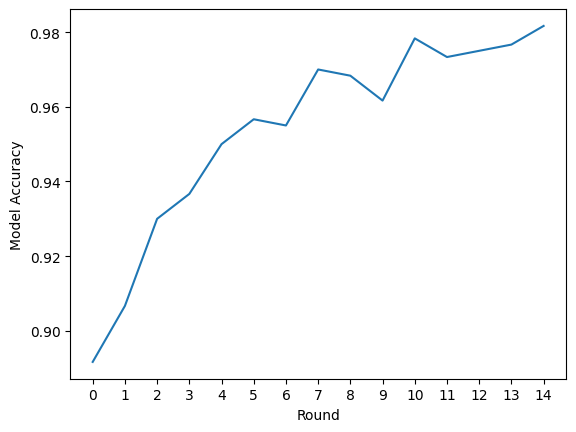

In [13]:
plt.plot(model_accuacy_arr)
plt.xticks(range(num_rounds))
plt.xlabel("Round")
plt.ylabel("Model Accuracy")
plt.show()

From the plot above, we can see that the model accuracy increases steadily with each additional round of collecting more labels, getting improved consensus labels, and model training.

## Other useful multiannotator statistics

After conducting multiple rounds of active learning, you can also obtain various multiannotator statistics such as the higher quality [CROWDLAB consensus label](https://arxiv.org/abs/2210.06812) for each example, consensus label quality scores, annotator quality scores and more for the examples that have been labeled. 

Below we show a simple example of how to obtain this information using the annotators' labels and the model predicted probabilites. Check out cleanlab's [multiannotator module](https://docs.cleanlab.ai/stable/tutorials/multiannotator.html) for more detailed information!

In [14]:
# using the annotator labels and predicted probabilites to get the consensus labels and other statistics
multiannotator_results = get_label_quality_multiannotator(multiannotator_labels, pred_probs_labeled)

In [15]:
# each row of the dataframe corresponds to an example, here you can get the CROWDLAB consensus label and its quality score
multiannotator_results["label_quality"].head()

,consensus_label,consensus_quality_score,annotator_agreement,num_annotations
0,0,0.859215,1.000000,1
1,3,0.915668,1.000000,1
2,2,0.347822,0.181818,11
3,1,0.990000,1.000000,1
4,1,0.889130,1.000000,1


In [16]:
# each row of the dataframe corresponds to an annotator, here you can get their annotator quality and other information about the annotators
multiannotator_results["annotator_stats"].head()

,annotator_quality,agreement_with_consensus,worst_class,num_examples_labeled
32,0.360373,0.41,3,100
33,0.368573,0.41,3,100
44,0.370940,0.43,3,100
43,0.385489,0.55,3,100
31,0.387211,0.45,3,100
